##### Master Degree in Computer Science and Data Science for Economics

# Sequence 2 sequence generation with attention

### Alfio Ferrara

See also the [PyTorch tutorial](https://pytorch.org/tutorials/intermediate/char_rnn_generation_tutorial.html)

### Preparazione dei dati

In [4]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from roman_arabic_numerals import conv

In [5]:
folder = '../'
classification_path = '{}/data/roman_number-classification.csv'.format(folder)
data = pd.read_csv(classification_path)
data.head(2)

,sequence,target
0,___CXXXIII,odd
1,____CXCVII,odd


In [6]:
numbers = [x.replace('_', '') for x in data.sequence.values]
arabic = [str(conv.rom_arab(n)) for n in numbers]
numbers[:3], arabic[:3]

(['CXXXIII', 'CXCVII', 'XCIX'], ['133', '197', '99'])

#### Input and output
**Encoder**: vec(XII) $\rightarrow$ context_vector

**Decoder**:
$$
\textrm{context\_vector} \rightarrow \begin{matrix}
\langle SOS \rangle & \rightarrow & 1 \\
\langle 1 \rangle & \rightarrow & 2 \\
\langle 2 \rangle & \rightarrow & \langle EOS \rangle \\
\end{matrix}
$$

In [7]:
import nlp.utils

In [8]:
roman_vocabulary, arabic_vocabulary = nlp.utils.Lang(name='roman'), nlp.utils.Lang('arabic')

In [9]:
for i, r in enumerate(numbers):
    a = arabic[i]
    roman_vocabulary.add_word(r)
    arabic_vocabulary.add_word(a)

## Training

### Data preparation

In [10]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler
import torch 
import nlp.neurnets as net 

In [11]:
input_vocabulary = roman_vocabulary
target_vocabulary = arabic_vocabulary

def indexes_from_word(lang, word):
    return [lang.letter2index[c] for c in word]

def word_tensor(lang, word):
    indexes = indexes_from_word(lang, word)
    indexes.append(nlp.utils.EOS_token)
    return torch.tensor(indexes, dtype=torch.long).view(1, -1)

def pari_tensors(pair):
    input_tensor = word_tensor(input_vocabulary, pair[0])
    target_tensor = word_tensor(target_vocabulary, pair[1])
    return (input_tensor, target_tensor)

def get_dataloader(batch_size):
    input_lang, output_lang, pairs = input_vocabulary, target_vocabulary, [(n, arabic[i]) for i, n in enumerate(numbers)]

    n = len(pairs)
    input_ids = np.zeros((n, net.MAX_LENGTH), dtype=np.int32)
    target_ids = np.zeros((n, net.MAX_LENGTH), dtype=np.int32)

    for idx, (inp, tgt) in enumerate(pairs):
        inp_ids = indexes_from_word(input_lang, inp)
        tgt_ids = indexes_from_word(output_lang, tgt)
        inp_ids.append(nlp.utils.EOS_token)
        tgt_ids.append(nlp.utils.EOS_token)
        input_ids[idx, :len(inp_ids)] = inp_ids
        target_ids[idx, :len(tgt_ids)] = tgt_ids

    train_data = TensorDataset(torch.LongTensor(input_ids), torch.LongTensor(target_ids))
    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
    return input_lang, output_lang, train_dataloader

In [12]:
batch_size = 4
input_lang, output_lang, train_dataloader = get_dataloader(batch_size=batch_size)

### Training functions

In [13]:
from tqdm.notebook import tqdm
from torch import nn 

In [14]:
def train_epoch(dataloader, encoder, decoder, encoder_optimizer,
        decoder_optimizer, criterion):

    total_loss = 0
    for input_tensor, target_tensor in dataloader:
        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()
        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden, target_tensor)
        loss = criterion(
            decoder_outputs.view(-1, decoder_outputs.size(-1)),
            target_tensor.view(-1)
        )
        loss.backward()
        encoder_optimizer.step()
        decoder_optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)

def train(train_dataloader, encoder, decoder, n_epochs, 
        learning_rate=0.001, plot_every=100):
    history = []
    plot_loss_total = 0  # Reset every plot_every
    encoder_optimizer = torch.optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss()
    run = list(range(n_epochs))
    for epoch in tqdm(run):
        loss = train_epoch(train_dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
        plot_loss_total += loss

        if epoch % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            history.append(plot_loss_avg)
            plot_loss_total = 0

    return history

## Training

In [15]:
hidden_size = 16
batch_size = 4
epochs = 200

input_lang, output_lang, train_dataloader = get_dataloader(batch_size)

encoder = net.EncoderRNN(input_lang.n_letters, hidden_size)
decoder = net.DecoderRNN(hidden_size, output_lang.n_letters)

history = train(train_dataloader, encoder, decoder, epochs, plot_every=5)

  0%|          | 0/200 [00:00<?, ?it/s]

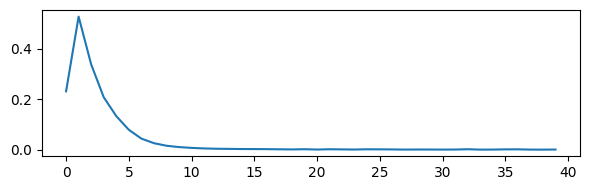

In [16]:
fig, ax = plt.subplots(figsize=(6, 2))
ax.plot(history)
plt.tight_layout()
plt.show()

## Evaluation

In [19]:
def evaluate(encoder, decoder, word, input_lang, output_lang):
    with torch.no_grad():
        input_tensor = word_tensor(input_lang, word=word)

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, decoder_hidden, decoder_attn = decoder(encoder_outputs, encoder_hidden)

        _, topi = decoder_outputs.topk(1)
        decoded_ids = topi.squeeze()

        decoded_letters = []
        for idx in decoded_ids:
            if idx.item() == nlp.utils.EOS_token:
                decoded_letters.append('<EOS>')
                break
            decoded_letters.append(output_lang.index2letter[idx.item()])
    return decoded_letters, decoder_attn

In [20]:
encoder.eval()
decoder.eval()
test = 'IX'
out, attn = evaluate(encoder, decoder, test, roman_vocabulary, arabic_vocabulary)
print(out)

['9', '3', '<EOS>']


In [21]:
attention = attn[0].detach().numpy()
attention.shape

(10, 3)

In [22]:
attention

array([[0.37177414, 0.4531789 , 0.17504692],
       [0.08589604, 0.8654336 , 0.04867036],
       [0.24984838, 0.46345487, 0.2866968 ],
       [0.14968519, 0.46844575, 0.38186902],
       [0.12316672, 0.26143762, 0.6153956 ],
       [0.11905257, 0.33187008, 0.54907733],
       [0.11219683, 0.3796571 , 0.5081461 ],
       [0.10628123, 0.40500605, 0.48871276],
       [0.10208482, 0.4196843 , 0.4782309 ],
       [0.09916969, 0.42876887, 0.47206137]], dtype=float32)